In [2]:
import numpy as np
from scipy.signal import correlate, welch
from scipy.io import wavfile as wav
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from scipy.fft import fft

In [3]:
def read_audios(og, rec):

    sample_rate1, audio_original = wav.read(og)
    sample_rate2, audio_grabado = wav.read(rec)
    audio_original = audio_original / 32767
    audio_grabado = audio_grabado / 32767
    audio_original -= np.mean(audio_original)
    audio_grabado -= np.mean(audio_grabado)
    try:
        audio_grabado = audio_grabado.mean(axis=1).astype(audio_grabado.dtype)
        audio_original = audio_original.mean(axis=1).astype(audio_original.dtype)
    except:
        pass

    
    return audio_original, audio_grabado

def calc_delay(audio_original, audio_grabado):

    # Calculate the phase correlation between the two signals
    sig1 = audio_grabado
    sig2 = np.concatenate((audio_original,np.zeros(len(audio_grabado)-len(audio_original))))

    sig1 = sig1 / np.linalg.norm(sig1)
    sig2 = sig2 / np.linalg.norm(sig2)


    cross_correlation = correlate(sig1, sig2)

    # Find the time delay (in samples) corresponding to the maximum phase correlation
    delay_samples = np.argmax(cross_correlation)-int(len(sig1)-1)

    # Calculate the time delay in seconds
    delay_seconds = delay_samples / 48000
    return delay_samples

def make_filter(M, r, p, var):
    wo = linalg.solve_toeplitz(r[:M],p[:M], check_finite= True)
    Jo = var - p[:M].dot(wo)
    return wo, Jo


1.

Señal de Voz: Sin perder de vista que el objetivo del trabajo es modelar la respuesta al impulso de un sistema parlante-habitación-micrófono; se toma una grabación de voz donde intentamos ampliar el rango de frecuencias recorrido a lo largo del audio. Esto es para que el sistema reaccione a las diferentes componentes que podemos alcanzar en el habla regular dentro de la habitación. De otra forma, al grabar un audio donde hablemos de manera calma perdemos capacidad de análisis frente a las componentes disponibles de nuestro sistema, empeorando la estimación que podemos llegar a obtener.


Musica: Elegimos una canción de Metallica, una banda caracterizada por su amplia gama de frecuencias alcanzadas debido al estilo de música que realizan.
La guitarra eléctrica, el bajo, la voz del cantante y la batería; permiten obtener componentes en frecuencia de prácticamente todo el espectro audible, permitiendo un mejor analisis de respuesta del sistema; al observar como responde nuestro sistema frente a estas transiciones de amplitud y frecuencia.

In [4]:
og = ["./audios_originales/lin_og.wav",
      "./audios_originales/exp_og.wav",
      "./audios_originales/metallica_og.wav",
      "./audios_originales/audio_og.wav",
      "./audios_originales/square_og.wav", 
      "./audios_originales/white_noise_og.wav"
      ]
rec = ["./grabaciones/lin_rec.wav",
      "./grabaciones/exp_rec.wav",
      "./grabaciones/metallica_rec.wav",
      "./grabaciones/audio_rec.wav",
      "./grabaciones/square_rec.wav", 
      "./grabaciones/white_noise_rec.wav"]
labels = ['linear sweep', 'exponential sweep', 'song', 'voice', 'square', 'white noise']

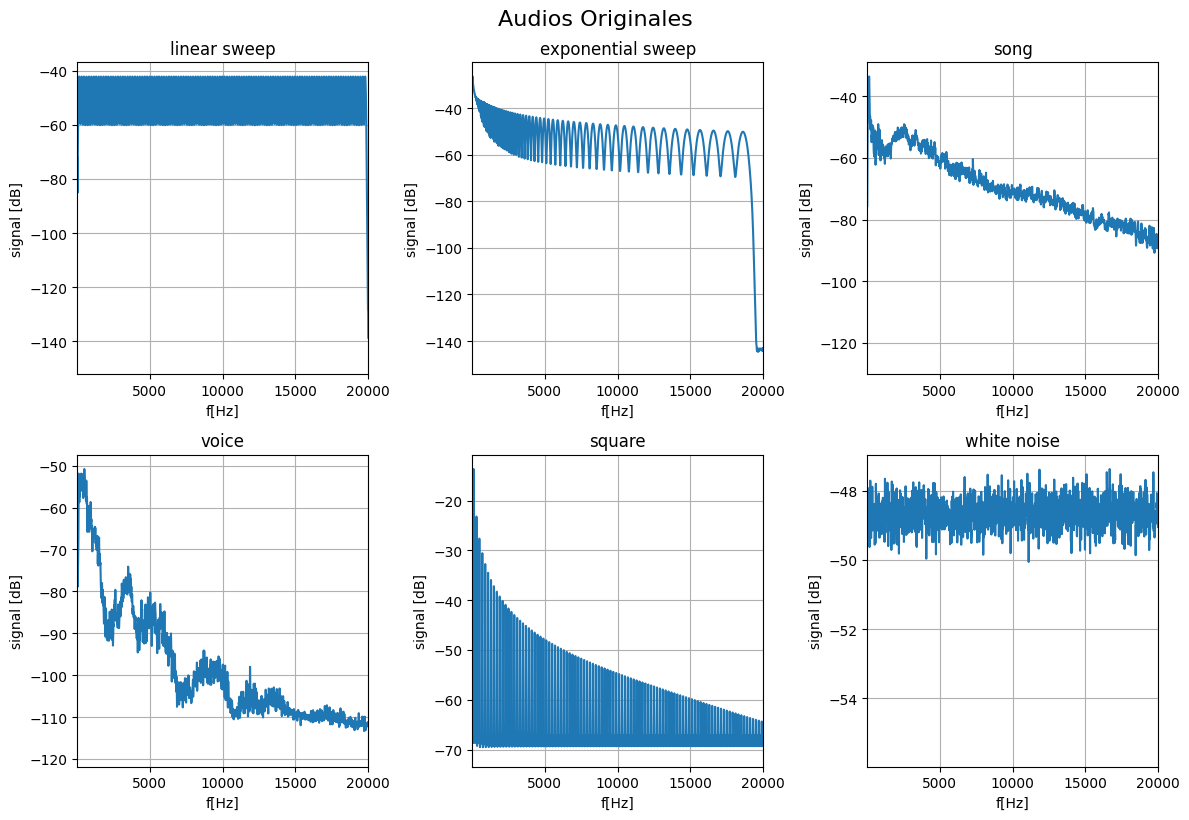

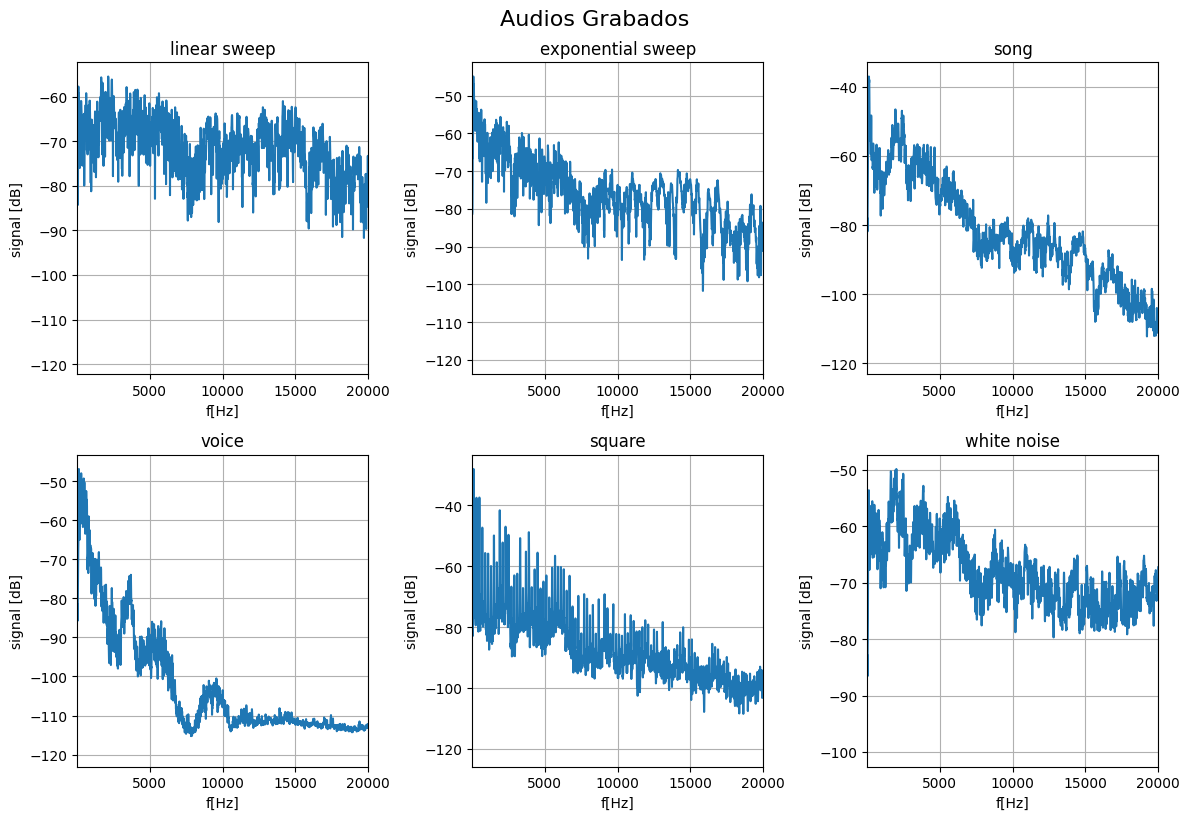

In [5]:

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over the subplots and plot data in each one
for i in range(6):
    row = i // 3  # Calculate the row index (0 or 1)
    col = i % 3   # Calculate the column index (0, 1, or 2)
    
    audio_original, audio_grabado = read_audios(og[i], rec[i])
    f, Pxx_den = welch(audio_original, fs=48000, window='parzen', nperseg=6000, noverlap=2000, detrend='constant', return_onesided=True, scaling='density')
    plt.xlim(20,20000)
    # Plot data in the corresponding subplot
    axs[row, col].plot(f, 10*np.log10(Pxx_den))
    
    # Customize subplot labels, titles, etc., as needed
    axs[row, col].set_xlabel('f[Hz]')
    axs[row, col].set_ylabel('signal [dB]')
    axs[row, col].set_title(labels[i])
    axs[row, col].set_xlim(20,20000)
    axs[row, col].grid(which='both')

# Adjust layout and spacing
plt.tight_layout()
fig.suptitle('Audios Originales', fontsize=16,  y=1.02)


# Show the plot
plt.show()

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over the subplots and plot data in each one
for i in range(6):
    row = i // 3  # Calculate the row index (0 or 1)
    col = i % 3   # Calculate the column index (0, 1, or 2)
    
    audio_original, audio_grabado = read_audios(og[i], rec[i])
    f, Pxx_den = welch(audio_grabado, fs=48000, window='parzen', nperseg=6000, noverlap=3000, detrend='constant', return_onesided=True, scaling='density')
    plt.xlim(20,20000)
    # Plot data in the corresponding subplot
    axs[row, col].plot(f, 10*np.log10(Pxx_den))
    
    # Customize subplot labels, titles, etc., as needed
    axs[row, col].set_xlabel('f[Hz]')
    axs[row, col].set_ylabel('signal [dB]')
    axs[row, col].set_title(labels[i])
    axs[row, col].set_xlim(20,20000)
    axs[row, col].grid(which='both')

# Adjust layout and spacing
plt.tight_layout()
fig.suptitle('Audios Grabados', fontsize=16,  y=1.02)
# Show the plot
plt.show()

2.
Como se comenta en el punto 1 de este trabajo, lo que se busca es estudiar todo el espectro audible dentro del sistema de la habitación;
y de esta forma poder modelar un mejor estimador de la respuesta del mismo. Por esta razon:

* Música: Podemos ver como el el espectro decae conforme al aumento de la frecuencia a estudiar. Pese a que permite identificar si la modelización es correcta debido a que es audiblemente distinguible, no parece ser la mejor estimación.
* Señal de Voz: podemos ver que la misma es una señal irregular con mucha varianza, entonces no podemos aprovechar totalmente componentes presentes
en la habitación, además de una resolución pésima cuando lo que se busca es encontrar un estimador óptimo. Además, como en el caso de la música, el espectro decae en con la frecuencia. 
* Señal Cuadrada: El hecho de que sea 100Hz su armónico principal es un limitante para muchos parlantes, y pese a que pudimos evitar este problema empleando
un sistema de audio que reproduce desde los 40Hz, la mayor cantidad de energía se encuentra en torno a este armónico y decaerá en forma de 'deltas' 
cuasi-periódicamente. A causa de esto no podemos capturar todo el rango de frecuencias buscado.
* Ruido Blanco Gaussiano: La señal de Ruido Blanco Gaussiano es una señal que abarca todo el espectro buscado con una distribución uniforme de su energia.
Esto es favorable a la hora de estimar el sistema, pero no es óptimo debido a la falta de un patrón (alta presencia de componentes estocásticas) en el espectro 
que nos permita una fácil modelización.
* Barrido lineal en frecuencia o barrido exponencial: En este caso ambos espectros abarcan el rango de frecuencias a estudiar, permitiendo una amplia gama de
respuestas de nuestro sistema. La utilización de uno por sobre otro se debe a que el barrido lineal lo hace de manera uniforme, lo que si bien no permite detectar 
respuestas en frecuencias específicas, nos permite estudiar por igual todas las componentes. En cambio el barrido exponencial, prepondera las altas frecuencias;
que si hubieramos tenido problemas a la hora de elegir un sistema de audio nos hubiera ayudado a dar mayor importancia a las señales que permita reproducir.
En nuestro caso, subjetivamente podriamos optar por la señal de barrido exponencial debido a que escuchamos de manera logarítmica, pero que luego tengamos 
una respuesta que se acople a nuestra audición no significa que podamos obtener el mejor estimador a partir de ella. 

Por todo lo expuesto anteriormente, optamos por la elección del barrido lineal como base de nuestro estimador de la respuesta impulsiva.

3. A continuación se itera el proceso de adaptación del filtro para diferentes ordenes tomando como exitación al barrido lineal en frecuencia. El objetivo de este proceso es observar el comportamiento de Jo a medida que M aumenta.  

In [6]:
audio_original, audio_grabado = read_audios(og[0], rec[0])
delay_samples = calc_delay(audio_original, audio_grabado)
audio_grabado = audio_grabado[delay_samples:delay_samples+480000]


audio_grabado = audio_grabado/ np.linalg.norm(audio_grabado)
audio_original = audio_original/ np.linalg.norm(audio_original)

r = correlate(audio_original, audio_original, 'full')[len(audio_original)-1:] / len(audio_original)
p = correlate(audio_grabado, audio_original, 'full')[len(audio_original)-1:] / len(audio_original)

m_array = [int(x) for x in (np.logspace(0, 4.2, num = 500))]
Jo_array = []
Epsilon_array = []
for m in m_array:
    var_rec = np.var(audio_grabado)
    wo, Jo = make_filter(m, r, p, var_rec)
    Jo_array.append(Jo)
    Epsilon_array.append(Jo/var_rec)

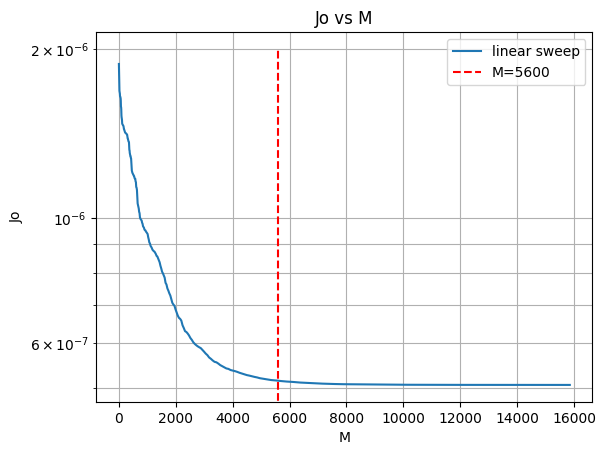

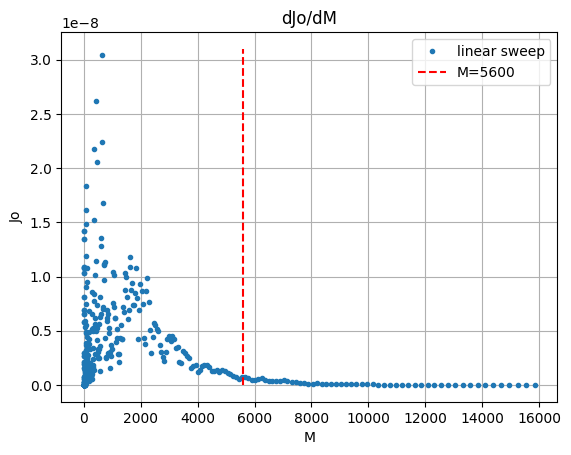

In [7]:

plt.title('Jo vs M')
plt.xlabel('M')
plt.ylabel('Jo')
plt.grid(which='both')
plt.semilogy(m_array, Jo_array,label = labels[0])
plt.plot([5600, 5600], [0, 2E-6], 'r--', label='M=5600')
plt.legend()
plt.show()
plt.title('dJo/dM')
plt.xlabel('M')
plt.ylabel('Jo')
plt.grid(which='both')
plt.plot(m_array,abs(np.gradient(Jo_array)),'.',label = labels[0])
plt.plot([5600, 5600], [0, 3.1E-8], 'r--', label='M=5600')
plt.legend()

Observando el comportamiento del MMSE, concluimos que un valor que aproxima al filtro adaptado es M=5600, ya que aproximadamente a partir de este punto podemos despreciar la caida del MMSE frente al aumento del orden del filtro empleado, ya que la derivada se aproxima a 0. Seguir aumentando M implica una mayor complejidad computacional sin mejora de la performance.

Resolver el sistema Toeplitz de la manera directa, invirtiendo matrices, es muy costoso computacionalmente. Una alternativa que mejora esta penalidad es el algoritmo recursivo de Levinson–Durbin. Este algoritmo tiene un costo computacional de Θ(n^2), mientras que si se resolviera directamente sería Θ(n^3). La funcion empleada para resolver elsistema (scipy.linalg.solve_toeplitz) utiliza esta técnica.

pto4

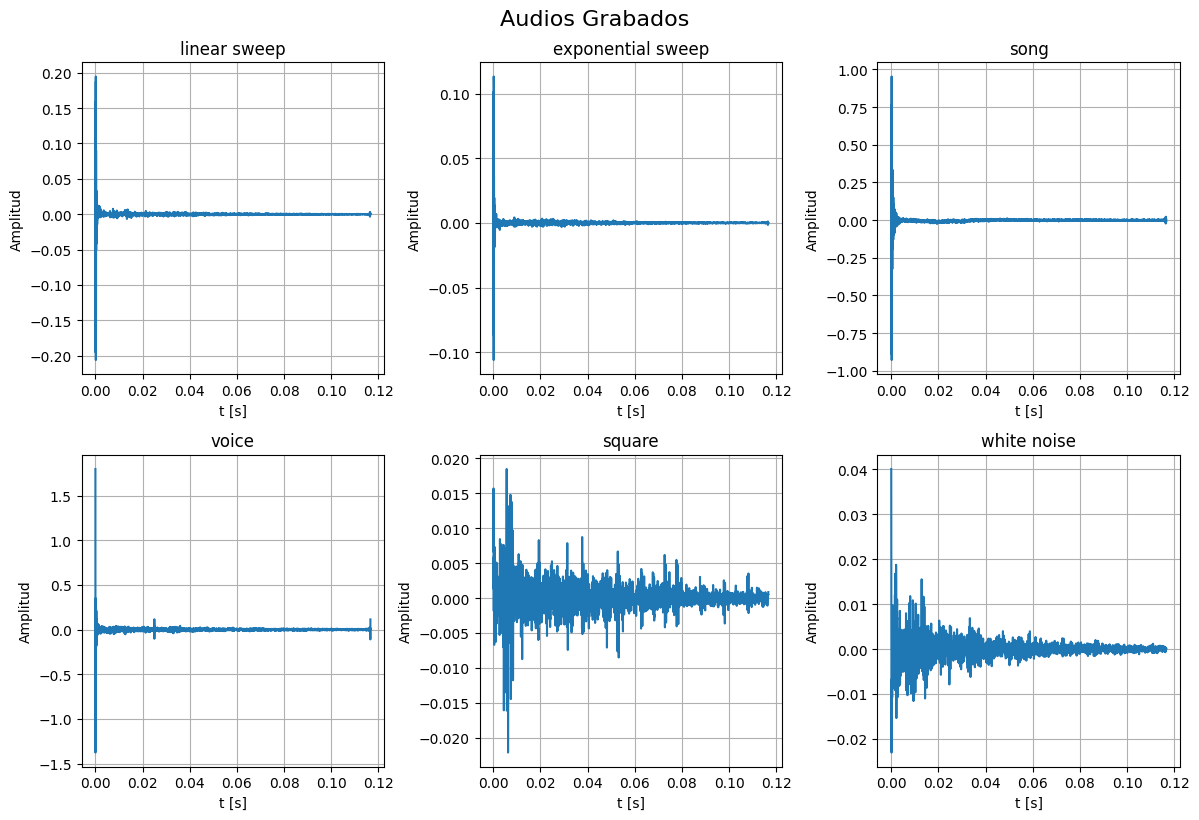

In [8]:
M=5600

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
wo_array =[]
Jo_array = []
E_array=[]
# Iterate over the subplots and plot data in each one
for i in range(6):
    row = i // 3  # Calculate the row index (0 or 1)
    col = i % 3   # Calculate the column index (0, 1, or 2)

    audio_original, audio_grabado = read_audios(og[i], rec[i])
    delay_samples = calc_delay(audio_original, audio_grabado)
    audio_grabado = audio_grabado[delay_samples:delay_samples+480000]

    audio_grabado = audio_grabado
    audio_original = audio_original

    r = correlate(audio_original, audio_original, 'full')[len(audio_original)-1:] / len(audio_original)
    p = correlate(audio_grabado, audio_original, 'full')[len(audio_original)-1:] / len(audio_original)

    wo, Jo = make_filter(M, r, p, np.var(audio_grabado))
    Jo_array.append(Jo)
    E_array.append(Jo/np.var(audio_grabado))
    wo_array.append(wo)
    
    # Plot data in the corresponding subplot
    axs[row, col].plot(np.array(range(len(wo)))/48000,wo)
    
    # Customize subplot labels, titles, etc., as needed
    axs[row, col].set_xlabel('t [s]')
    axs[row, col].set_ylabel('Amplitud')
    axs[row, col].set_title(labels[i])
    axs[row, col].grid()
    #axs[row, col].set_xlim(20,20000)

# Adjust layout and spacing
plt.tight_layout()
fig.suptitle('Audios Grabados', fontsize=16,  y=1.02)
# Show the plot
plt.show()

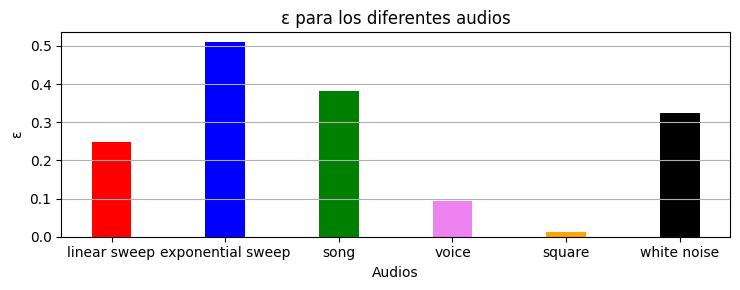

In [9]:
import matplotlib.pyplot as plt
import numpy as np



# Create an array for the x-axis positions
x = np.arange(len(labels))

# Define the width of each bar
bar_width = 0.35

# Create the grouped bar chart
plt.figure(figsize=(7.5, 3))
plt.bar(x, E_array, bar_width, color=["red", "blue", "green", "violet", "orange","black"])

# Adding labels and title
plt.xlabel('Audios')
plt.ylabel('ε')
plt.title('ε para los diferentes audios')
plt.xticks(x, labels)
plt.grid(axis="y")

# Show the plot
plt.tight_layout()
plt.show()


En cuanto al error relativo es notable cómo es más fácil para el filtro tener un menor error cuadrado en los casos donde los tonos de la excitación son menos variados en frecuencia. Tal es el caso especialmente de la señal cuadrada, cuyo espectro se correspondo con una serie de deltas, y a la voz, cuya banda de potencia es limitada, teniendo la banda que va hasta aproximadamente 2000hz una preponderancia en potencia respecto del resto. Ésta mejor adaptación no se traduce necesariamente en una mejor reproducción de la respuesta al impulso, ya que claramente la falta de tonos no permite representar correctamente la respuesta frente a todo el espectro de frecuencias. 

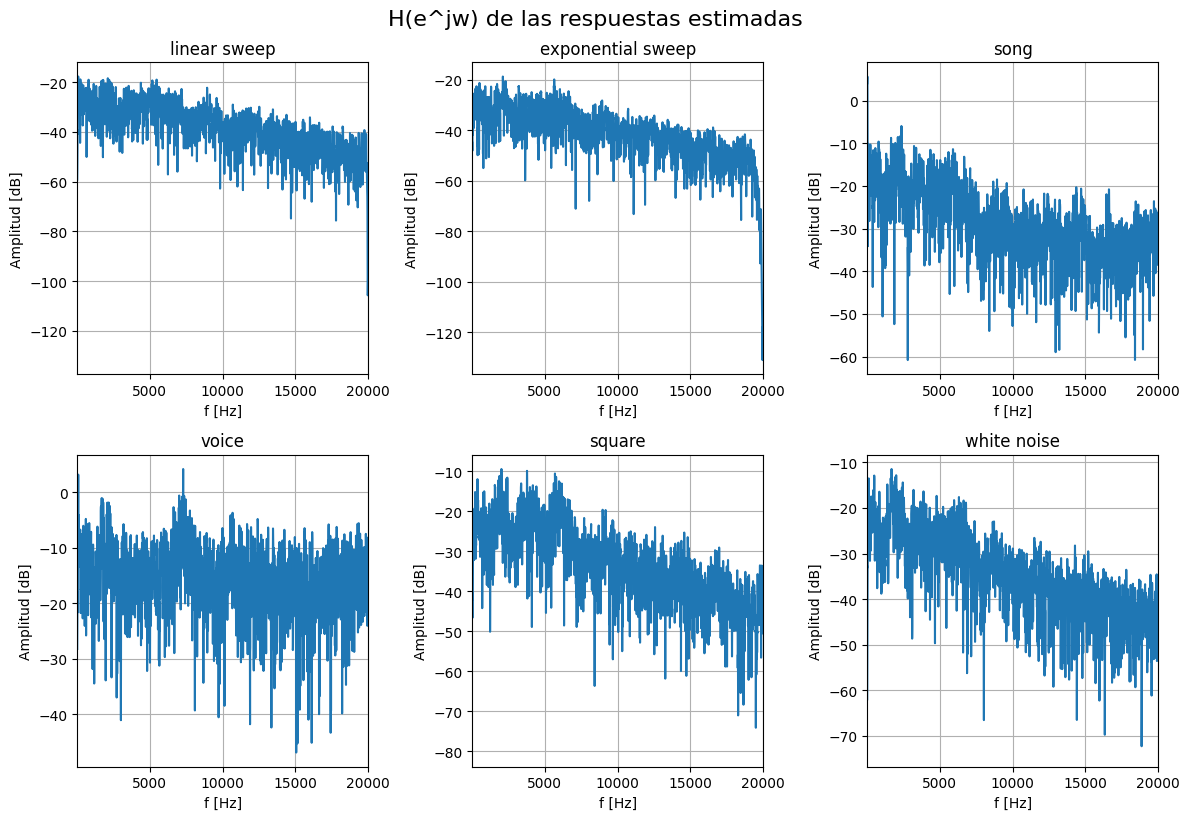

In [10]:
from scipy.signal.windows import parzen
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
# Iterate over the subplots and plot data in each one

for i in range(6):
    row = i // 3  # Calculate the row index (0 or 1)
    col = i % 3   # Calculate the column index (0, 1, or 2)


    fft_result = np.fft.fft(wo_array[i]*parzen(len(wo_array[i])))
    freqs = np.fft.fftfreq(len(fft_result), 1/48000)
    
    # Plot data in the corresponding subplot
    N = len(freqs)
    axs[row, col].plot(freqs[:N//2], 20*np.log10(abs(fft_result)[:N//2]))
    
    # Customize subplot labels, titles, etc., as needed
    axs[row, col].set_xlabel('f [Hz]')
    axs[row, col].set_ylabel('Amplitud [dB]')
    axs[row, col].set_title(labels[i])
    axs[row, col].set_xlim(20,20000)
    axs[row, col].grid(which='both')



# Adjust layout and spacing
plt.tight_layout()

fig.suptitle('H(e^jw) de las respuestas estimadas', fontsize=16,  y=1.02)
# Show the plot
plt.show()

Es notorio que todas las respuestas parecen corresponderse de manera general con un pasabajos excepto el caso de la voz, que parece más bien un pasabandas. También la cuadrada parece hacer énfasis en ciertas bandas aunque incorpora una atenuacíón con la frecuencia. También es notorio que los barridos resultan en filtros muy similares, con la diferencia clara siendo el notch del exponencial en frecuencias más altas. 

In [13]:
audio_original, _ = read_audios('./audios_originales/metallica_og.wav','./grabaciones/metallica_rec.wav')
for i in range(6):
    convolved_result = np.convolve(audio_original, wo_array[i], mode='same')
    sample_rate = 48000
    convolved_result_scaled = np.int16(convolved_result/np.max(abs(convolved_result)) * 32767)
    output_file = "./fake_recordings/fake"+labels[i]+".wav"
    wav.write(output_file, sample_rate, convolved_result_scaled)

Finalmente comparamos de manera subjetiva los resultados de la adaptación del filtro. Así, observamos cual de las distintas excitaciones permite imitar mejor la grabación original. Mediante un ejercicio de comparación a ciegas llegamos a la conclusión de que al oido humano la respesentación más fiel fue la dada por el barrido exponencial, siendo un competidor cercano la grabación del propio audio. El método utilizado para esto fue hacer una preba entre los integrantes del grupo y algunos familiares y amigos. 

Los resultados fueron sobre un total de 7 votantes:

4 votos: barrido exponencial

3 votos: grabacion de la canción


Esto puede ser así porque el barrido exponencial concentra su potencia, como se ve en los periodogramas de las excitaciones, en frecuencias más bajas. Es en estas frecuencias que la audición humana es más sensible. Por esto puede resultar que la señal emulada con el barrido exponencial suene más natural que su alternativa similar, el barrido lineal, que es el que a priori esperabamos que tuviera un mejor sonido. Este presunción se debe a que debería simular mejor una delta, por contar con una potencia distribuida más regularmente en el espectro de frecuencia. 

Hay que mencionar que tanto el barrido lineal como el ruido blanco también crean representaciones razonables al oido humano, aunque -a nuestro juicio- peores que las ya mencionadas. En cuanto a la peor represenctación se dio un consenso general de que corresponde a la imitación creada mediante la voz humana. Esto tiene sentido, dado el rango acotado en frecuencia de los tonos de la misma. 
